In [1]:
import networkx as nx
import pandas as pd
import itertools as it
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
from thefuzz import fuzz
mpl.rcParams['pdf.fonttype'] = 42

def get_unambiguous_column_names(column_names):
    series = pd.Series(column_names)
    series[series.duplicated(keep = 'first')] = series[series.duplicated(keep = 'first')].apply(
        lambda x: x + '.1'
    )
    return series.to_list()

def parse_metabolomics_results(filename, delimiter = ',', quotechar = '"'):
    with open(filename) as csvfile:
        data = []
        entryid = None
        csvreader = csv.reader(
            csvfile,
            delimiter = delimiter,
            quotechar = quotechar
        )
        
        # get column names and make them unambiguous
        names = []
        for i in range(2):
            names = csvreader.__next__()
        
        names = get_unambiguous_column_names(names)
        
        add_names = [
                'Name2', 
                'Molecular Weight', 
                'RT [min]2', 
                'DeltaMass [ppm]', 
                'DBID', 
                'Reference List Name', 
                'mzLogic Score', 
                'ChemSpider ID', 
                'KEGG', 'HMDB', 
                'Mass List Search Results ID'
        ]
        add_names_set = set([k if not k in {'Name2', 'RT [min]2'} else k[:-1] for k in add_names]) # faster check
        series = None
        tmp_names = []
        add_rows = []
        
        def insert_addrow_into_series(series, names, values, add_names_set):
            series = series.copy()
            for k, v in zip(names, values):
                if k in add_names_set:
                    k = k + '2' if k in {'Name', 'RT [min]'} else k
                    series[k] = v if v else None

                elif k == 'KEGG ID':
                    series['KEGG'] = v if v else None
            
            return series
            
        for line in csvreader:
            if line[0]:
                if add_rows:
                    exact_match = False
                    partial_match = False
                    for row in add_rows:
                        if row[0] == series.Name:
                            data.append(
                                insert_addrow_into_series(
                                    series,
                                    tmp_names,
                                    row,
                                    add_names_set
                                )
                            )
                            exact_match = True
                            break
                    
                    if not exact_match:
                        for row in add_rows:
                            if fuzz.partial_ratio(row[0].lower(), series.Name.lower()) > 95:
                                data.append(
                                    insert_addrow_into_series(
                                        series,
                                        tmp_names,
                                        row,
                                        add_names_set
                                    )
                                )
                                partial_match = True
                                break
                    
                    if not partial_match:
                        data.append(series.copy())
                
                elif isinstance(series, pd.Series):
                    data.append(series.copy())
                    
                entryid = line[0]
                add_rows = []
                series = pd.Series(
                    {k: v for k, v in zip(names, line)}
                )
                
            elif line[1] == 'Name':
                tmp_names = [name for name in line if name]
            
            else:
                add_rows.append(line[1: 1 + len(tmp_names)])
    
    return pd.DataFrame(data, columns = names + add_names)

def clean_dataframe(df):
    no_kegg_rows = df.KEGG.isna()
    no_kegg = df.loc[no_kegg_rows, :].copy()
    kegg = df.loc[~no_kegg_rows, :].copy()
    for df in [kegg, no_kegg]:
        df.drop_duplicates(
            subset = ['ID', 'KEGG'],
            inplace = True
        )
    
    no_kegg = no_kegg.loc[~no_kegg.ID.isin(kegg.ID), :]
    return kegg, no_kegg

In [2]:
hilic = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_HILIC.csv')
hilic, no_kegg_hilic = clean_dataframe(hilic)
rp = parse_metabolomics_results('../raw/Results_Untargeted_Metabolomics_E14-P40_LK_Nova_results_RP.csv')
rp, no_kegg_rp = clean_dataframe(rp)

In [3]:
# combine hilic and rp in two different ways
def get_clean_coarse_group(x):
    x = x.split('/')[0].strip().lower()
    if x.startswith('bio'):
        x = 'bioenergetic process'
        
    elif x.startswith('nucleoside'):
        x = 'nucleoside metabolism'
    
    elif x.startswith('glycolysis'):
        x = 'glycolysis'
    
    elif x.startswith('lipid'):
        x = 'lipid metablism'
    
    elif x.startswith('purine'):
        x = 'nucleoside metabolism'
        
    elif x.startswith('aa'):
        x = 'aa metabolism'
        
    else:
        x = 'other'
        
    return x

basedata = {}
for key in ['RP', 'HILIC']:
    base = pd.read_csv(
        f'../raw/untargeted_Metabo_Results_LKnaus_annotated_DM_clean_annot_{key}.csv',
        header = 1
    ).loc[:, ['ID', 'Name Metabolite ', 'Group ']]
    base.columns = ['ID', 'metabolitename', 'metabolitegroupfine']
    base['metabolitegroupcoarse'] = base.metabolitegroupfine.apply(
        get_clean_coarse_group
    )

    frames = []
    for df in [hilic, no_kegg_hilic, rp, no_kegg_rp]:
        frames.append(
            base.merge(
                df,
                on = 'ID',
                how = 'inner'
            )
        )
    
    df = pd.concat(frames).reset_index(drop = True)
    df.index = df.ID.to_list()
    basedata[key] = df

In [4]:
basedata['HILIC']

,ID,metabolitename,metabolitegroupfine,metabolitegroupcoarse,Name,Calc. MW,RT [min],"(P40, KO) / (P40, WT)","(P2, KO) / (P2, WT)","(E14_5, KO) / (E14_5, WT)",...,Molecular Weight,RT [min]2,DeltaMass [ppm],DBID,Reference List Name,mzLogic Score,ChemSpider ID,KEGG,HMDB,Mass List Search Results ID
A002_HILIC,A002_HILIC,L-(+)-Alanine,AA Metabolism / Alanine,aa metabolism,L-(+)-Alanine,89.0477,14.83,0.0,-0.1,0.0,...,89.0477,14.80,0.34,A072,iHILIC_neg_2020,74.9275,5735,C00041,HMDB0000161,57
A054_HILIC,A054_HILIC,L-(+)-Arginine,AA metabolism / Arginine,aa metabolism,L-(+)-Arginine,174.1118,25.41,-0.1,0.6,0.3,...,174.1117,25.52,0.64,E3,iHILIC_pos_2020,92.7285,6082,C00062,HMDB0000517,285
A062_HILIC,A062_HILIC,"NG,NG-dimethylarginine",AA metabolism / Arginine,aa metabolism,"NG,NG-dimethylarginine",202.1431,22.44,0.4,0.8,0.2,...,202.1430,22.61,0.54,A105,iHILIC_pos_2020,54.5226,110375,C03626,HMDB0001539,437
B122_HILIC,B122_HILIC,Creatine,AA metabolism / Arginine / Glycine,aa metabolism,Creatine,131.0695,14.89,0.0,0.0,-0.1,...,131.0695,NaN,0.10,NaN,NaN,NaN,NaN,C00300,NaN,NaN
A012_HILIC,A012_HILIC,L-Creatinine,AA metabolism / Arginine / Glycine,aa metabolism,L-Creatinine,113.0590,7.62,-0.1,-0.1,-0.3,...,113.0589,7.61,0.76,E25,iHILIC_pos_2020,71.8107,568,C00791,HMDB0000562,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C166_RP,C166_RP,2-arachidonoyl-sn-glycero-3-phosphocholine,Lipid metabolism / Phospholipid synthesis,lipid metablism,2-arachidonoyl-sn-glycero-3-phosphocholine,543.3329,28.56,0.3,0.5,-0.2,...,543.3325,NaN,0.69,NaN,NaN,18.2198109,NaN,NaN,NaN,NaN
C164_RP,C164_RP,2-arachidonyl-sn-glycero-3-phosphoethanolamine,Lipid metabolism / Phospholipid synthesis,lipid metablism,2-arachidonyl-sn-glycero-3-phosphoethanolamine,501.2858,28.35,0.6,0.2,0.4,...,501.2855,NaN,0.47,NaN,NaN,55.38292991,NaN,NaN,NaN,NaN
C161_RP,C161_RP,L-alpha-lysophosphatidylcholine,Lipid metabolism / Phospholipid synthesis,lipid metablism,L-alpha-lysophosphatidylcholine,467.3015,27.41,0.4,0.1,-0.2,...,467.3012,NaN,0.56,NaN,NaN,26.82693678,NaN,NaN,NaN,NaN
C116_RP,C116_RP,Phosphoryethanolamine,Lipid metabolism / Phospholipid synthesis,lipid metablism,Phosphoryethanolamine,141.0192,3.73,0.1,-0.2,-0.2,...,141.0191,NaN,0.74,NaN,NaN,None,NaN,NaN,NaN,NaN


In [5]:
data = basedata['HILIC']
networks = {}
genotype = 'WT'
def make_node(row):
    node = (
        row['ID'],
        {
            'name': row['metabolitename'],
            'group': row['metabolitegroupcoarse']
        }
    )
    return node
for timepoint in ['E14_5', 'P2', 'P40']:
    G = nx.Graph()
    G.add_nodes_from(
        [make_node(row) for i, row in data.iterrows()]
    )
    
    gtdata = data.loc[
        :, 
        data.columns[
            data.columns.str.match('S[0-9]{2}_' + timepoint + '_' + genotype + '[0-9]')
        ]
    ].astype(float)
    edges = []
    for (i, m1), (j, m2) in it.combinations(
        enumerate(gtdata.index), 2
    ):
        r = pearsonr(
            gtdata.loc[m1, :], gtdata.loc[m2, :]
        )[0]
        
        if abs(r) >= 0.5:
            edges.append(
                (m1, m2, {'weight': r})
            )
    
    G.add_edges_from(edges)
    networks[timepoint] = G

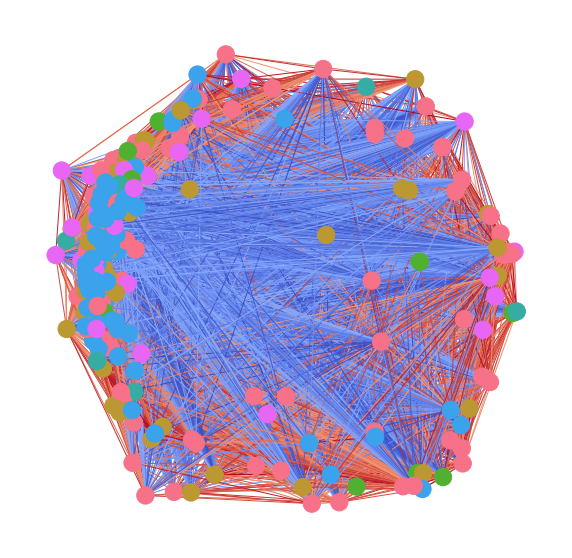

In [6]:
import seaborn as sns
fig, ax = plt.subplots()
G = networks['P2']
palette = sns.color_palette('husl', data.metabolitegroupcoarse.nunique())
node_group_colors = {
    group: palette[i] for i, group in enumerate(data.metabolitegroupcoarse.unique())
}
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
nx.draw(
    G, 
    ax = ax, 
    node_color = [
        node_group_colors[group] for n, group in G.nodes.data('group')
    ],
    edge_color = [
        cmap(norm(weight)) for n1, n2, weight in G.edges.data('weight')
    ],
    pos = nx.spring_layout(G)
)
fig.set_figwidth(10)
fig.set_figheight(10)

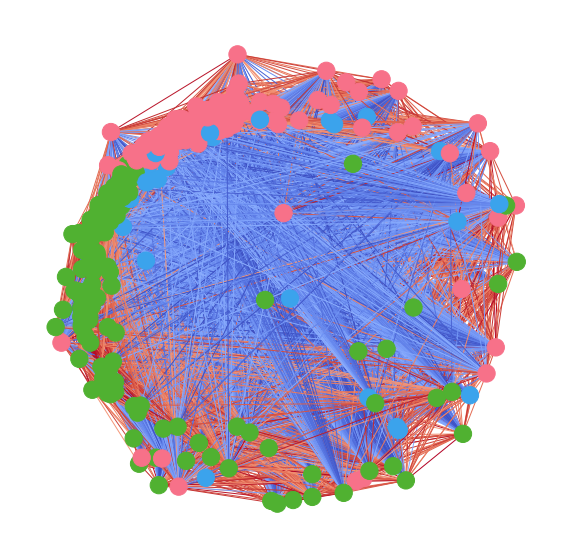

In [21]:
import networkx.algorithms.community as nx_comm
G = networks['P2']
communities = nx_comm.louvain_communities(G, resolution = 1)
community_dict = {}
for i, community in enumerate(communities):
    for node in community:
        community_dict[node] = i

palette = sns.color_palette('husl', len(communities))
fig, ax = plt.subplots()
node_colors = [palette[community_dict[node]] for node in G.nodes]
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
nx.draw(
    G, 
    ax = ax, 
    node_color = node_colors,
    edge_color = [
        cmap(norm(weight)) for n1, n2, weight in G.edges.data('weight')
    ],
    pos = nx.spring_layout(G)
)
fig.set_figwidth(10)
fig.set_figheight(10)